# Comportamenti delle reti di stazioni

In [21]:
source("load.R");
source("load_utils.R");
source("plot_helpers.R");
library(arrow);
library(tibble);
library(dplyr);
library(ggplot2);
library(sf);
library(rlang);
library(zeallot);
library(patchwork);
options(repr.plot.width=15, repr.plot.height=16)
temp <- "temp/pairing"
use_cache <- TRUE

In [2]:
# Matching/loading functions.
build_matches <- function(db1, db2) {
    st_join(
        db1,
        db2, st_is_within_distance,
        dist = units::set_units(10, "m"), suffix = c(".x", ".y"), left = FALSE
    ) |> st_drop_geometry()
}

to_series <- function(metadata_matches, series1, series2, tvar) {
    # Transform a dataframe of matches into a dataframe of series
    ids1 <- metadata_matches |>
        pull(identifier.x) |>
        unique()
    series1 <- series1 |>
        as_tibble() |>
        drop_na() |>
        filter(identifier %in% ids1) |>
        rename(T = {{ tvar }})

    ids2 <- metadata_matches |>
        pull(identifier.y) |>
        unique()
    series2 <- series2 |>
        as_tibble() |>
        drop_na() |>
        filter(identifier %in% ids2) |>
        rename(T = {{ tvar }})

    series1 |>
        left_join(
            metadata_matches,
            join_by(identifier == identifier.x),
            # Ci sono casi in cui più stazioni SCIA sono associate alla stessa stazione DPC e viceversa, per esempio quando una stazione viene spostata.
            relationship = "many-to-many"
        ) |>
        inner_join(
            series2,
            join_by(identifier.y == identifier, date),
            relationship = "many-to-one"
        )
}

diff_series <- function(db1, db2, series1, series2, tvar, desc = NULL) {
    matches <- build_matches(db1, db2)
    matched_series <- cached_data(
        "JOIN",
        tvar,
        otherwise = function(db, tvar) {
            matches |>
                to_series(series1, series2, tvar) |>
                mutate(diff = T.x - T.y)
        },
        file.path("cache", "intermediates", "series"),
        suffix = desc,
        load_cache = use_cache & !is.null(desc)
    )
    list(metadata = matches, data = matched_series)
}

plot_hist_net <- function(data, diff_var) {
    ggplot(data = data |> filter(abs({{ diff_var }}) <= 1.05)) +
        geom_histogram(
            aes({{ diff_var }}),
            binwidth = 0.1,
            bins = 21,
            center = 0
        )
}

these_plots <- function(m.db1, m.db2, s.db1, s.db2, tvar, diff_tag, desc) {
    diffs <- diff_series(
        m.db1,
        m.db2,
        s.db1 |> filter(date >= "2010-01-01"),
        s.db2 |> filter(date >= "2010-01-01"),
        tvar,
        desc = desc
    )
    p_net <- plot_hist_net(diffs$data, diff) +
        facet_wrap(. ~ rete, ncol = 4, scales = "free_y") +
        labs(title = tvar, x = diff_tag)
    ggsave(str_glue("plots/hist_net_{diff_tag}_{tvar}.pdf"), p_net, width = 9, height = 12)
    p_state <- plot_hist_net(diffs$data, diff) +
        facet_wrap(. ~ state.x, ncol = 4, scales = "free_y") +
        labs(title = tvar, x = diff_tag)
    ggsave(str_glue("plots/hist_state_{diff_tag}_{tvar}.pdf"), p_state, width = 9, height = 18)
    list(diffs$data, p_net, p_state)
}
m.scia.tmax <- retrieve.metadata("SCIA", "T_MAX", load_cache = use_cache, overwrite = TRUE, verbose = FALSE)
s.scia.tmax <- retrieve.series("SCIA", "T_MAX", load_cache = use_cache, overwrite = TRUE, verbose = FALSE) |> filter(date >= as.Date("2010-01-01"))
m.scia.tmin <- retrieve.metadata("SCIA", "T_MIN", load_cache = use_cache, overwrite = TRUE, verbose = FALSE)
s.scia.tmin <- retrieve.series("SCIA", "T_MIN", load_cache = use_cache, overwrite = TRUE, verbose = FALSE) |> filter(date >= as.Date("2010-01-01"))
gc()

Cache found: SCIA->T_MAX, loading from disk

Cache found: SCIA->T_MAX, loading from disk

Cache found: SCIA->T_MIN, loading from disk

Cache found: SCIA->T_MIN, loading from disk



,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1470627,78.6,2621362,140.0,NA,2621362,140.0
Vcells,54765680,417.9,303700700,2317.1,16384,355558565,2712.7


## $\Delta \mathrm{T_{MAX}}$ SCIA-DPC

Cache found: DPC->T_MAX, loading from disk

Cache found: JOIN->T_MAX, loading from disk



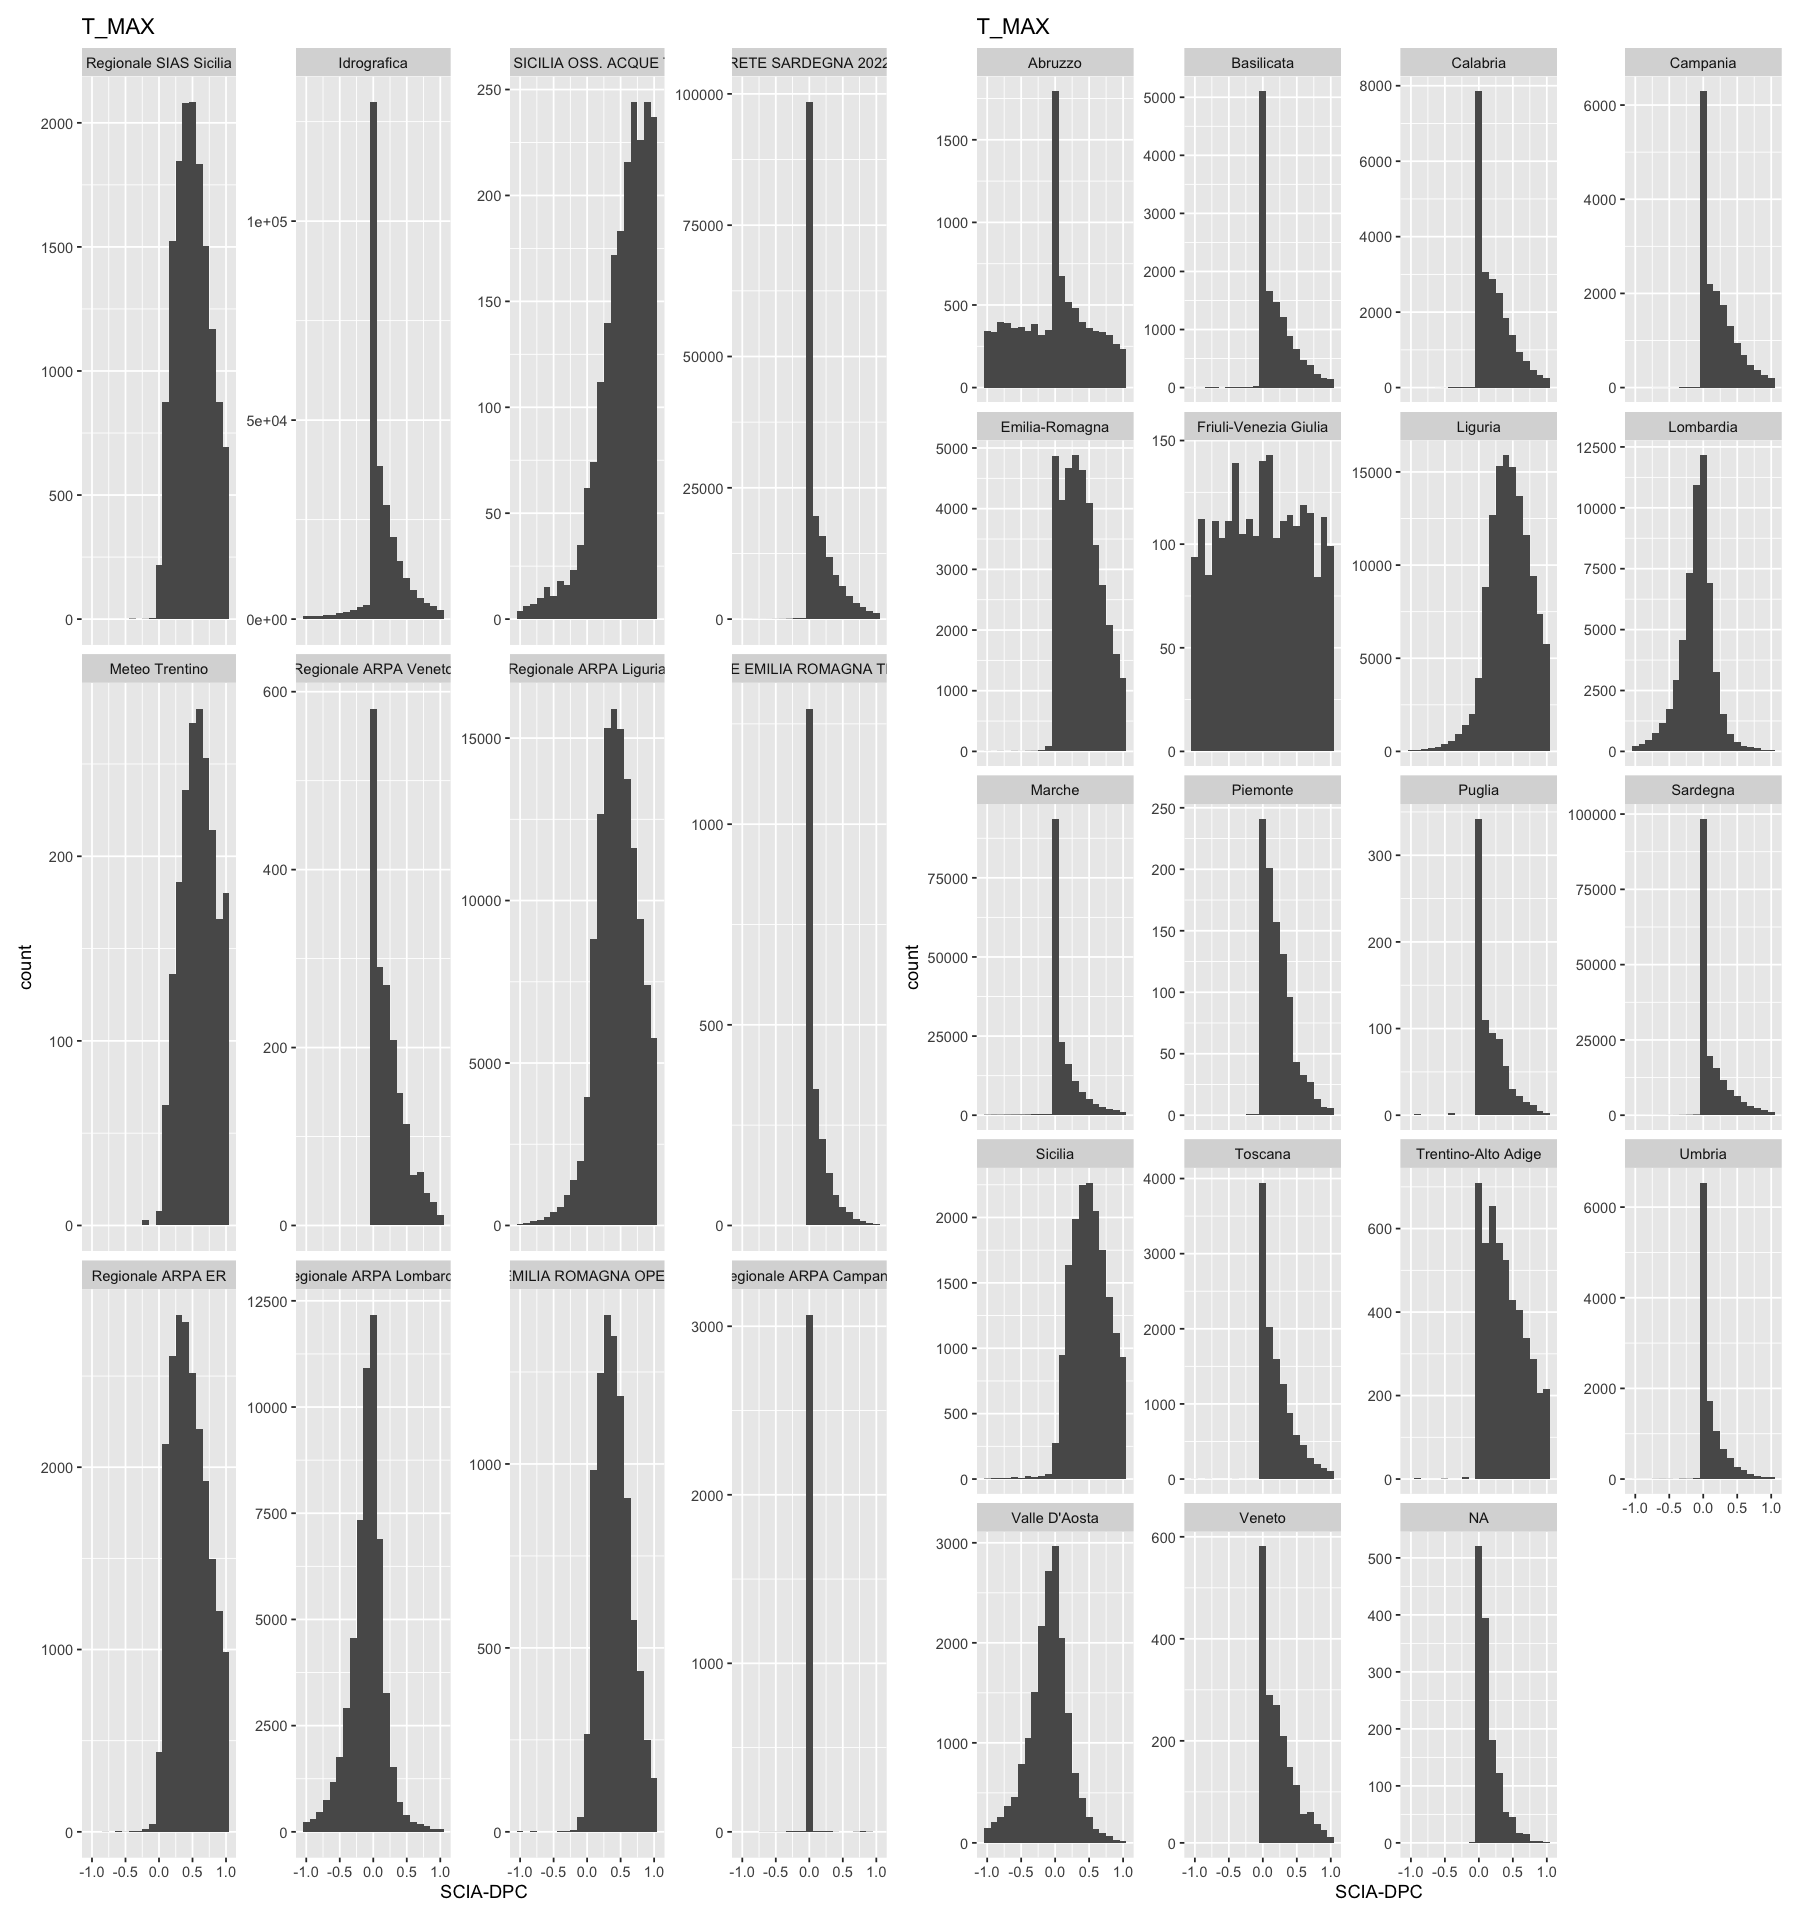

In [3]:
tvar <- "T_MAX"
c(d.tmax, p_net, p_state) %<-% these_plots(
    m.scia.tmax,
    retrieve.metadata("DPC", tvar, load_cache = use_cache, overwrite = TRUE),
    s.scia.tmax,
    retrieve.series("DPC", tvar, load_cache = use_cache, overwrite = TRUE) |> filter(date > as.Date("2010-01-01")),
    tvar,
    "SCIA-DPC",
    "_SCIA-DPC_2010"
)
p_net + p_state

## $\Delta \mathrm{T_{MIN}}$ SCIA-DPC

Cache found: DPC->T_MIN, loading from disk

Cache found: JOIN->T_MIN, loading from disk



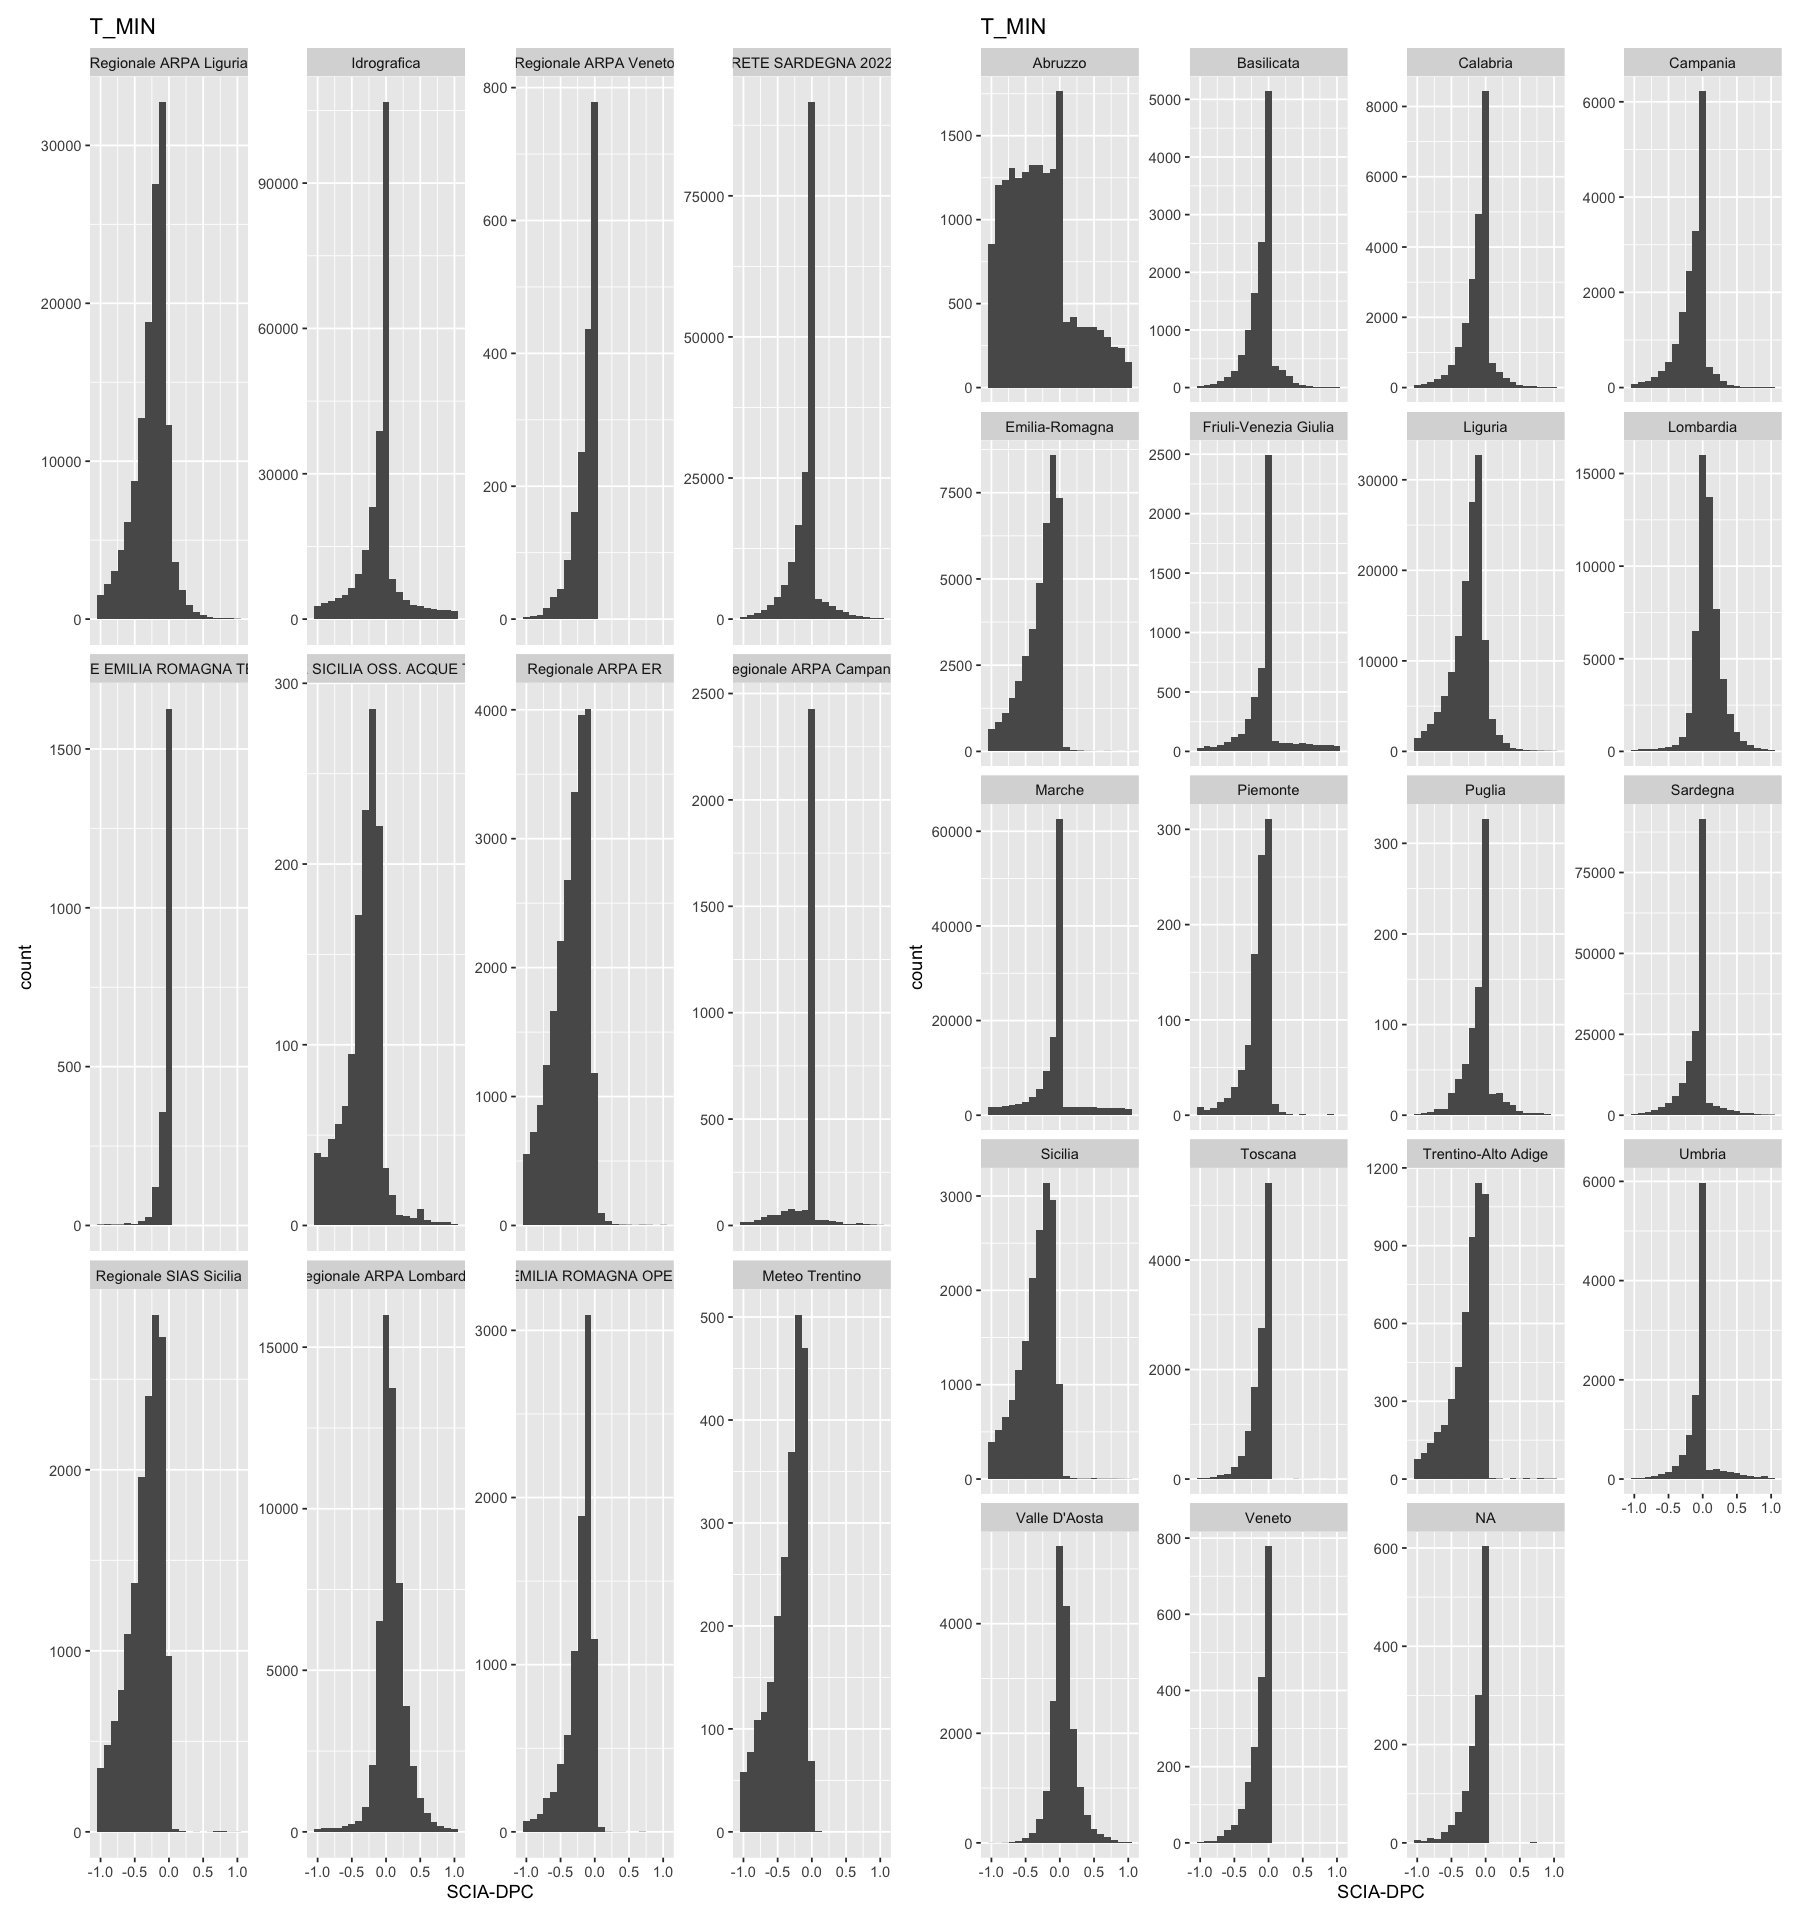

In [4]:
tvar <- "T_MIN"
c(d.tmin, p_net, p_state) %<-% these_plots(
    m.scia.tmin,
    retrieve.metadata("DPC", tvar, load_cache = use_cache, overwrite = TRUE),
    s.scia.tmin,
    retrieve.series("DPC", tvar, load_cache = use_cache, overwrite = TRUE) |> filter(date > as.Date("2010-01-01")),
    tvar,
    "SCIA-DPC",
    "_SCIA-DPC_2010"
)
p_net + p_state

Osservazioni:
- il trend per tutte le stazioni è compatibile con l'ipotesi che SCIA faccia statistiche su dati "grezzi" mentre DPC su medie orarie;
- per alcune reti il trend si presenta in maniera "assoluta" (nessuna eccezione), per altre no;
- Lombardia e Liguria seguono meno il trend;
- alcune reti hanno bias netti: Meteo Trentino, ER OpenData, SIAS Sicilia ad esempio hanno massimo nelle differenze su valori != 0.

## $\Delta \mathrm{T}$

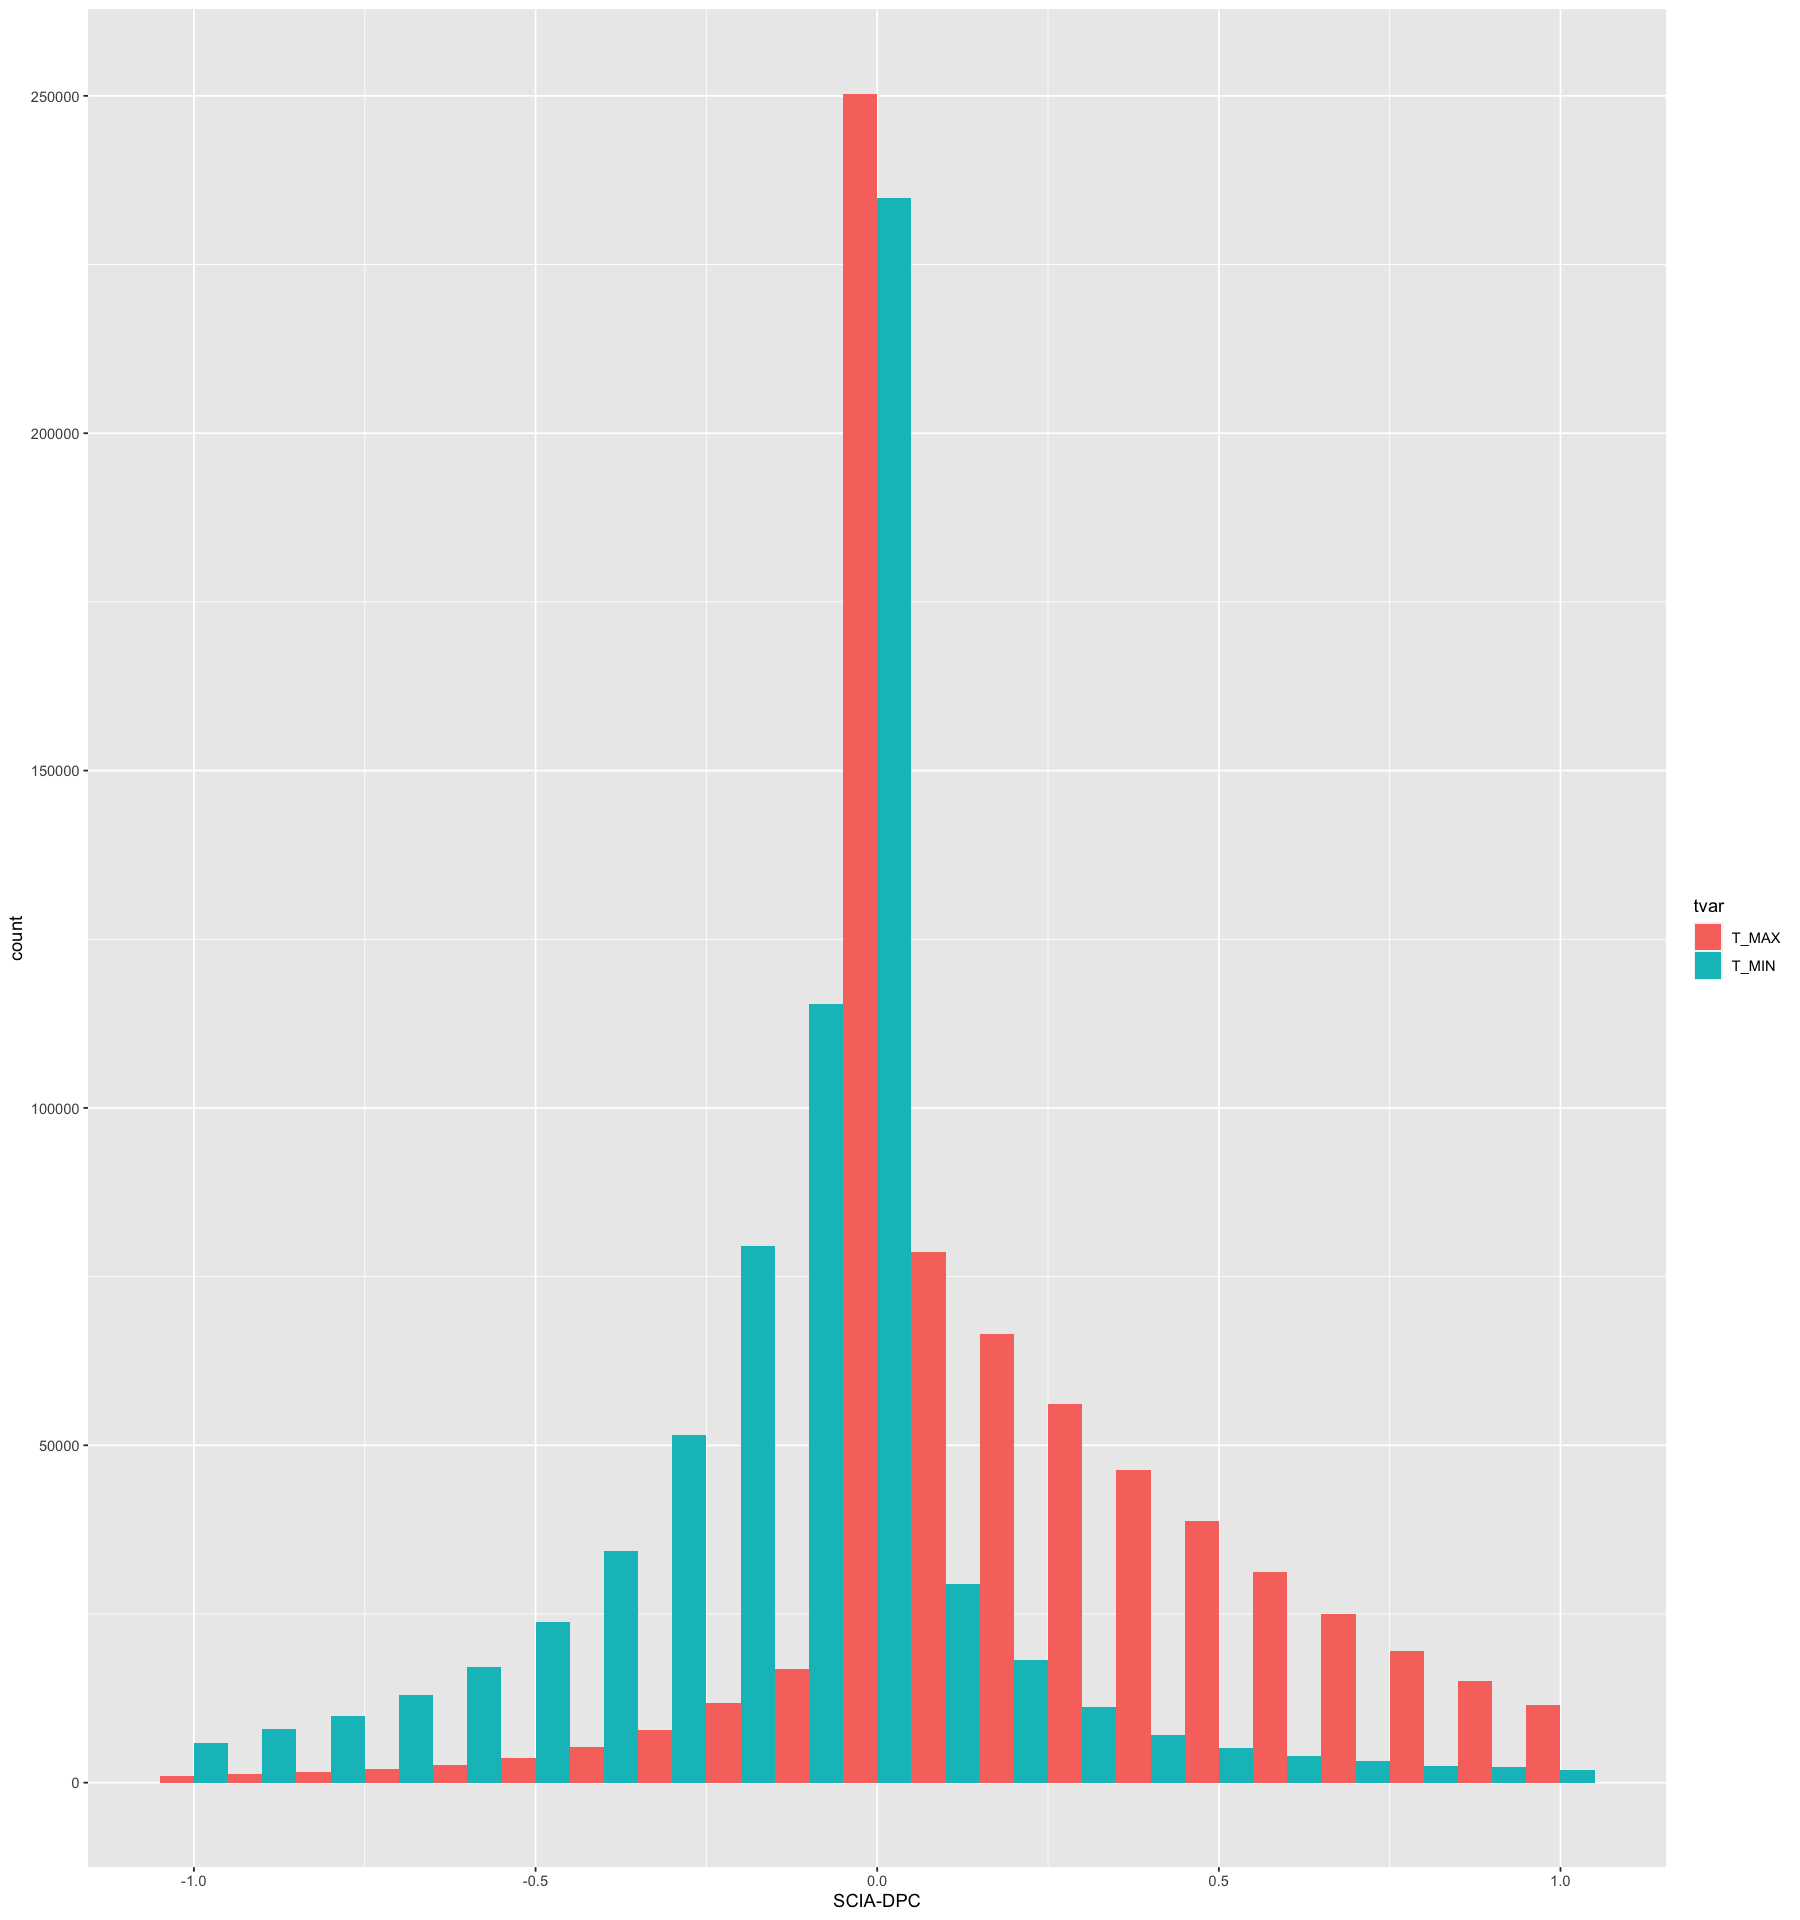

In [5]:
data <- bind_rows(
    T_MAX = d.tmax |> select(diff, elevation.x),
    T_MIN = d.tmin |> select(diff, elevation.x),
    .id = "tvar"
)
ggplot(data = data |> filter(abs(diff) <= 1.05)) +
    geom_histogram(
        aes(diff, fill = tvar),
        bins = 21,
        binwidth = 0.1,
        center = 0,
        position = "dodge",
    ) +
    labs(x = "SCIA-DPC")
ggsave(str_glue("plots/hist_net_both.pdf"), width = 12, height = 12)

## $\Delta \mathrm{T_{MAX}}$ SCIA-NODPC

Cache found: BRUN->T_MAX, loading from disk

Cache found: DPC->T_MAX, loading from disk

Cache found: BRUN->T_MAX, loading from disk

Cache found: JOIN->T_MAX, loading from disk



,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1943081,103.8,4053441,216.5,NA,4053441,216.5
Vcells,104401914,796.6,447831564,3416.7,16384,559507426,4268.8


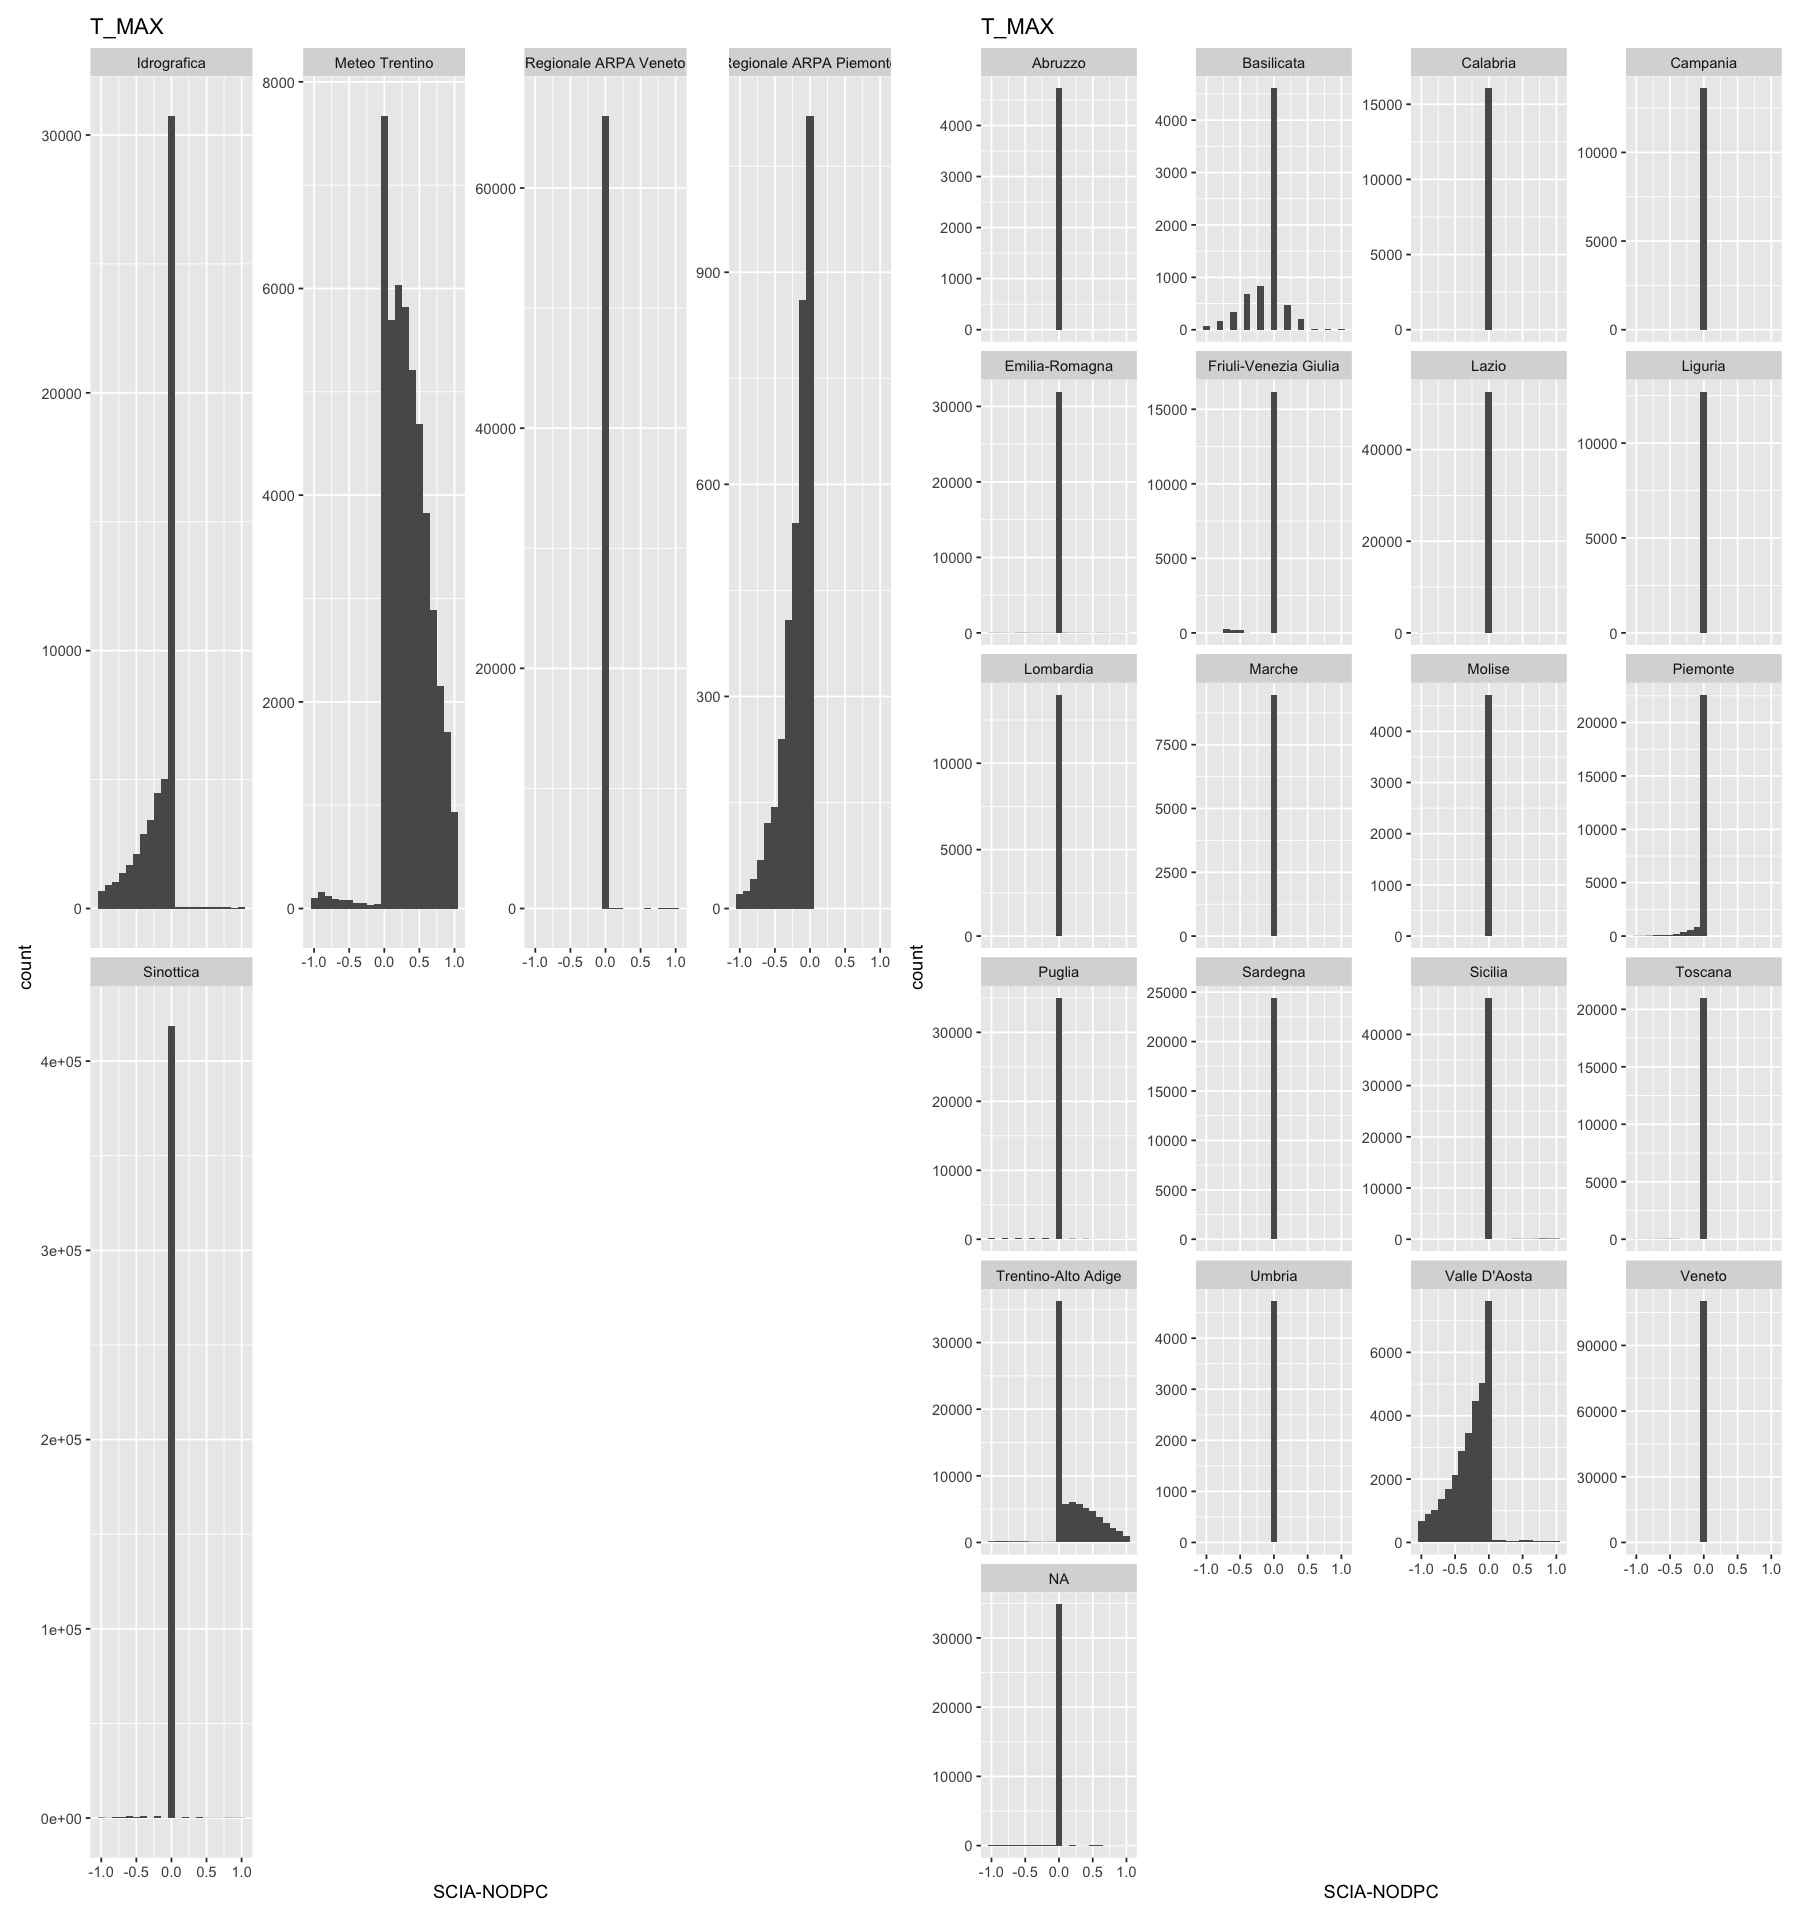

In [6]:
tvar <- "T_MAX"
m.brun <- retrieve.metadata("BRUN", tvar)
m.dpc <- retrieve.metadata("DPC", tvar)
m.nodpc <- anti_join(m.brun, m.dpc |> st_drop_geometry(), by = "identifier")
s.nodpc <- retrieve.series("BRUN", tvar) |> filter(identifier %in% m.nodpc$identifier, date > as.Date("2010-01-01"))
c(d.tmax, p_net, p_state) %<-% these_plots(
    m.scia.tmax,
    m.nodpc,
    s.scia.tmax,
    s.nodpc,
    tvar,
    "SCIA-NODPC",
    "_SCIA-NODPC_2010"
)
p_net + p_state
gc()


## $\Delta \mathrm{T_{MIN}}$ SCIA-NODPC

Cache found: BRUN->T_MIN, loading from disk

Cache found: DPC->T_MIN, loading from disk

Cache found: BRUN->T_MIN, loading from disk

Cache found: JOIN->T_MIN, loading from disk



,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1943936,103.9,4053441,216.5,NA,4053441,216.5
Vcells,102948654,785.5,429982301,3280.6,16384,559507426,4268.8


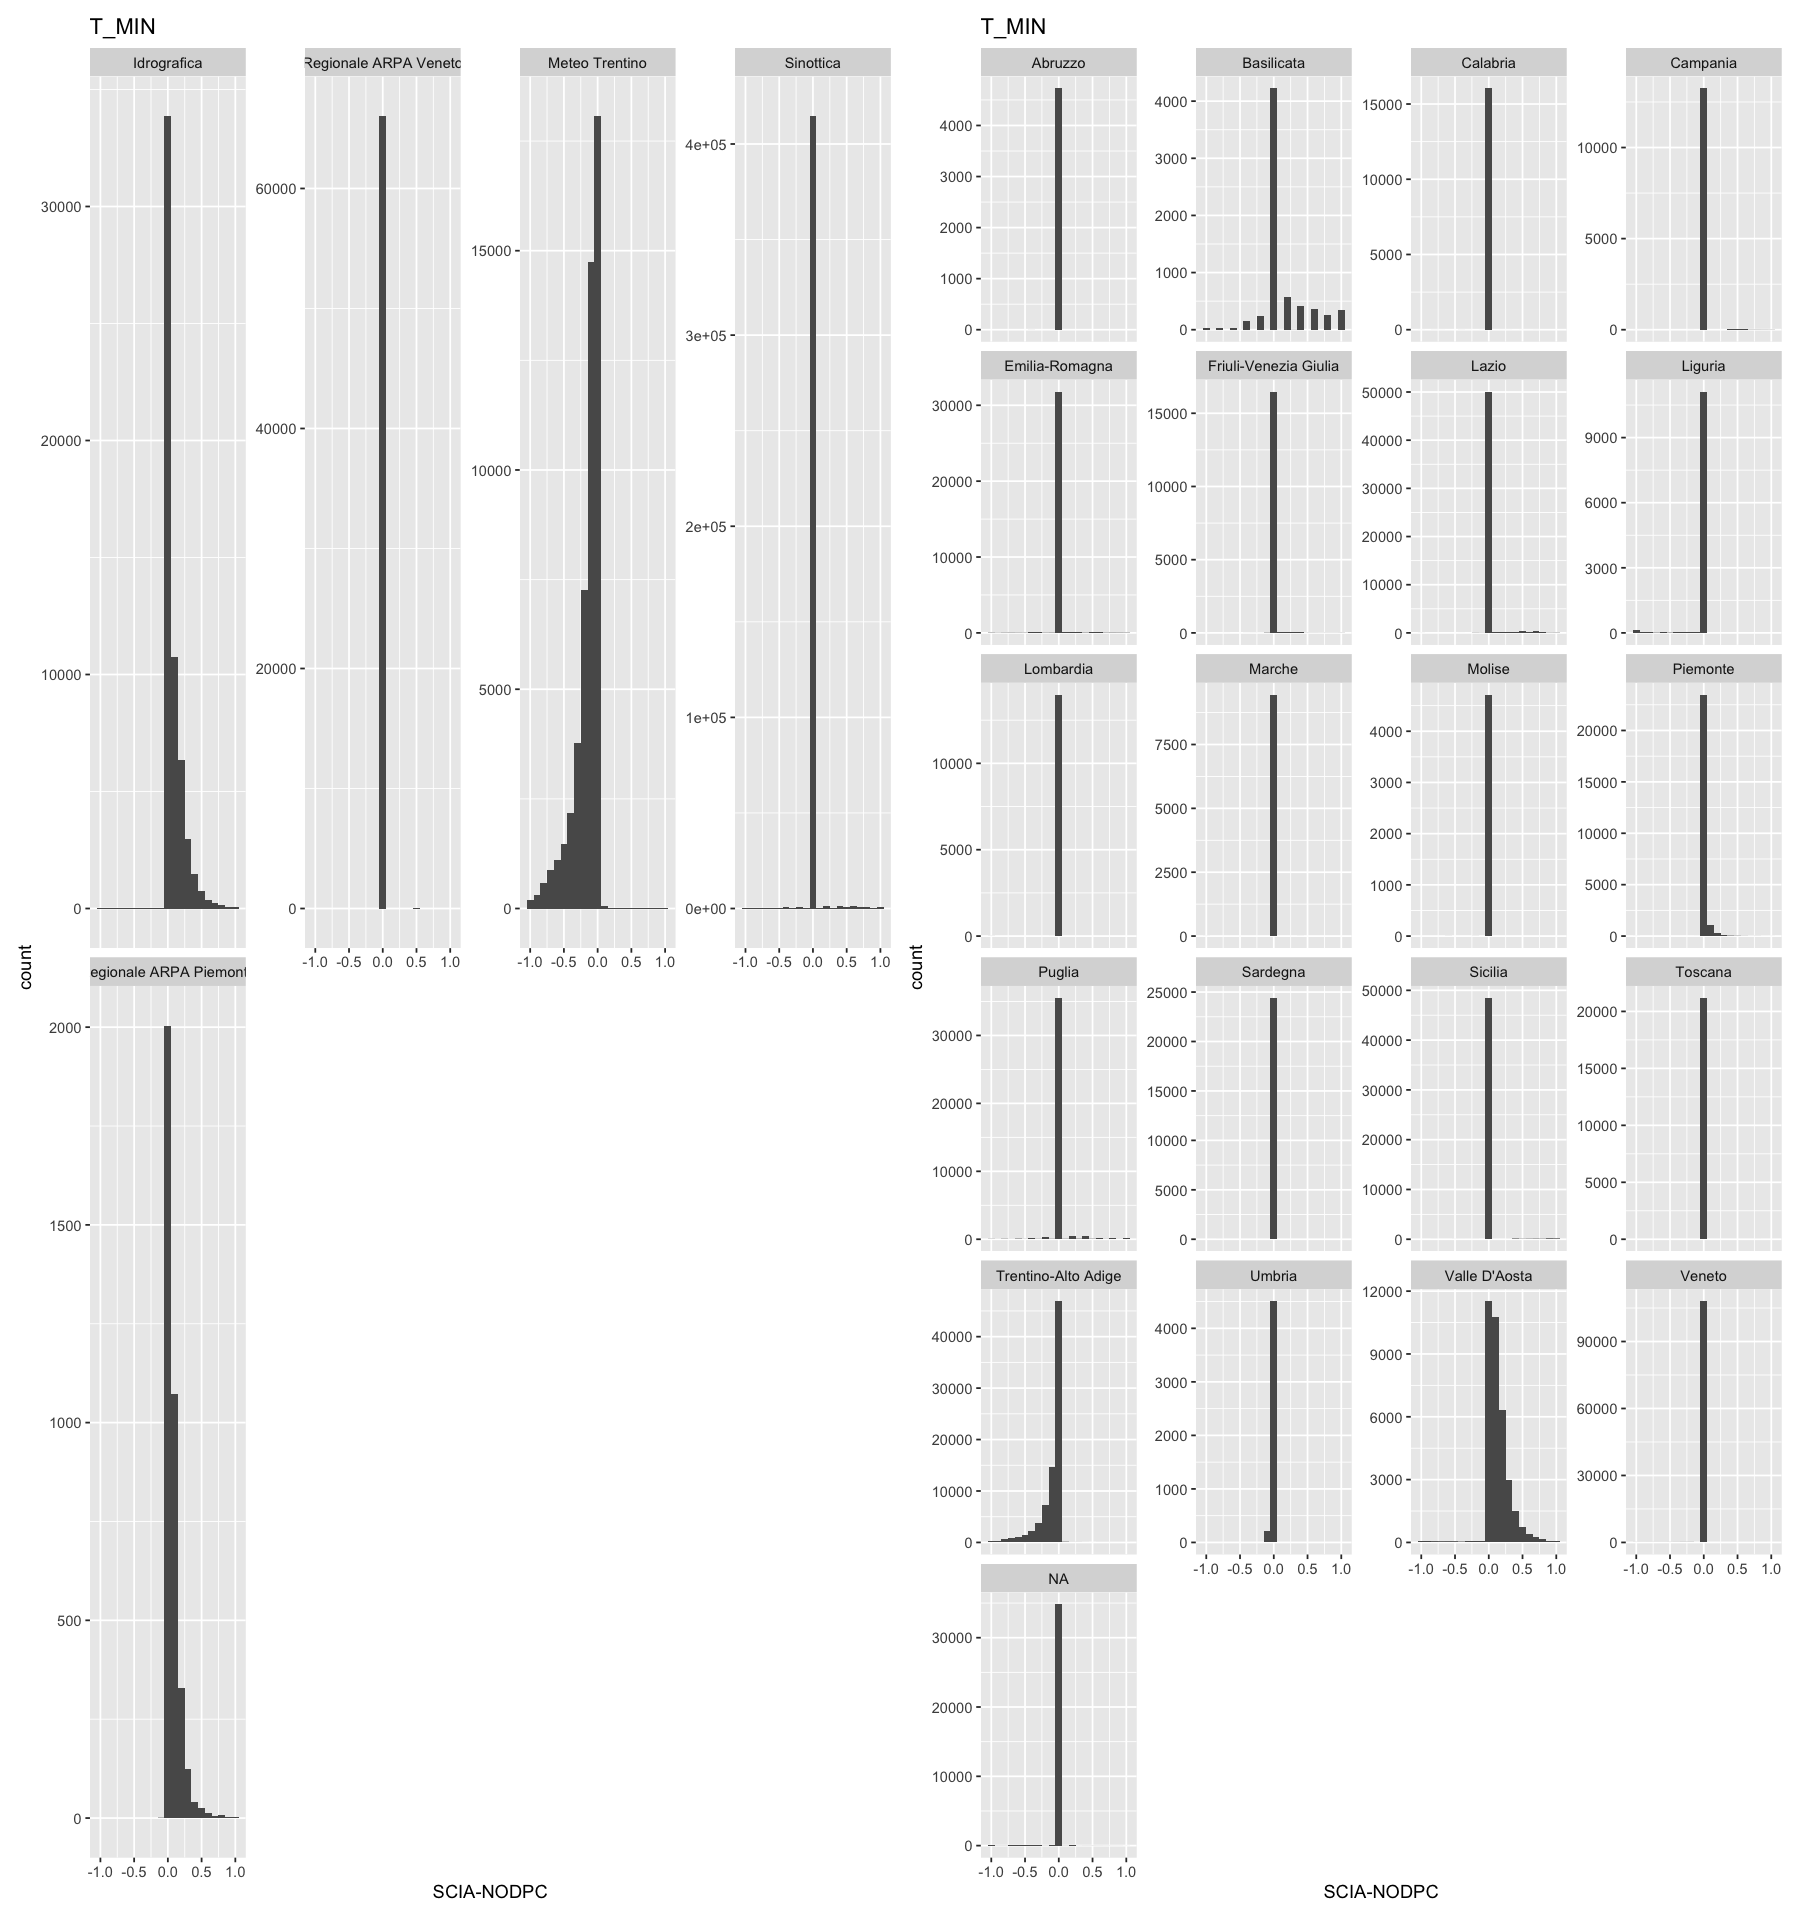

In [7]:
tvar <- "T_MIN"
m.brun <- retrieve.metadata("BRUN", tvar)
m.dpc <- retrieve.metadata("DPC", tvar)
m.nodpc <- anti_join(m.brun, m.dpc |> st_drop_geometry(), by = "identifier")
s.nodpc <- retrieve.series("BRUN", tvar) |> filter(identifier %in% m.nodpc$identifier, date > as.Date("2010-01-01"))
c(d.tmin, p_net, p_state) %<-% these_plots(
    m.scia.tmin,
    m.nodpc,
    s.scia.tmin,
    s.nodpc,
    tvar,
    "SCIA-NODPC",
    "_SCIA-NODPC_2010"
)
p_net + p_state
gc()


Osservazioni:
- Sinottica (AM) comunica registrazioni orarie: come c'è da aspettarsi le differenze non sono significative (non ho la questione "estremi assoluti vs estremi delle medie orarie");
- ARPA Piemonte si comporta come le stazioni DPC (ATTENZIONE: nell'analisi DPC non ho trovato match per questa rete!); Idrografica anche;
- ARPA Veneto ha differenze non significative;
- Meteo Trentino si comporta in maniera opposta. Comunica a SCIA statistiche orarie mentre a NODPC no? La cosa strana è che per le stazioni DPC invece funziona nella maniera attesa...

## $\Delta \mathrm{T}$ SCIA-NODPC

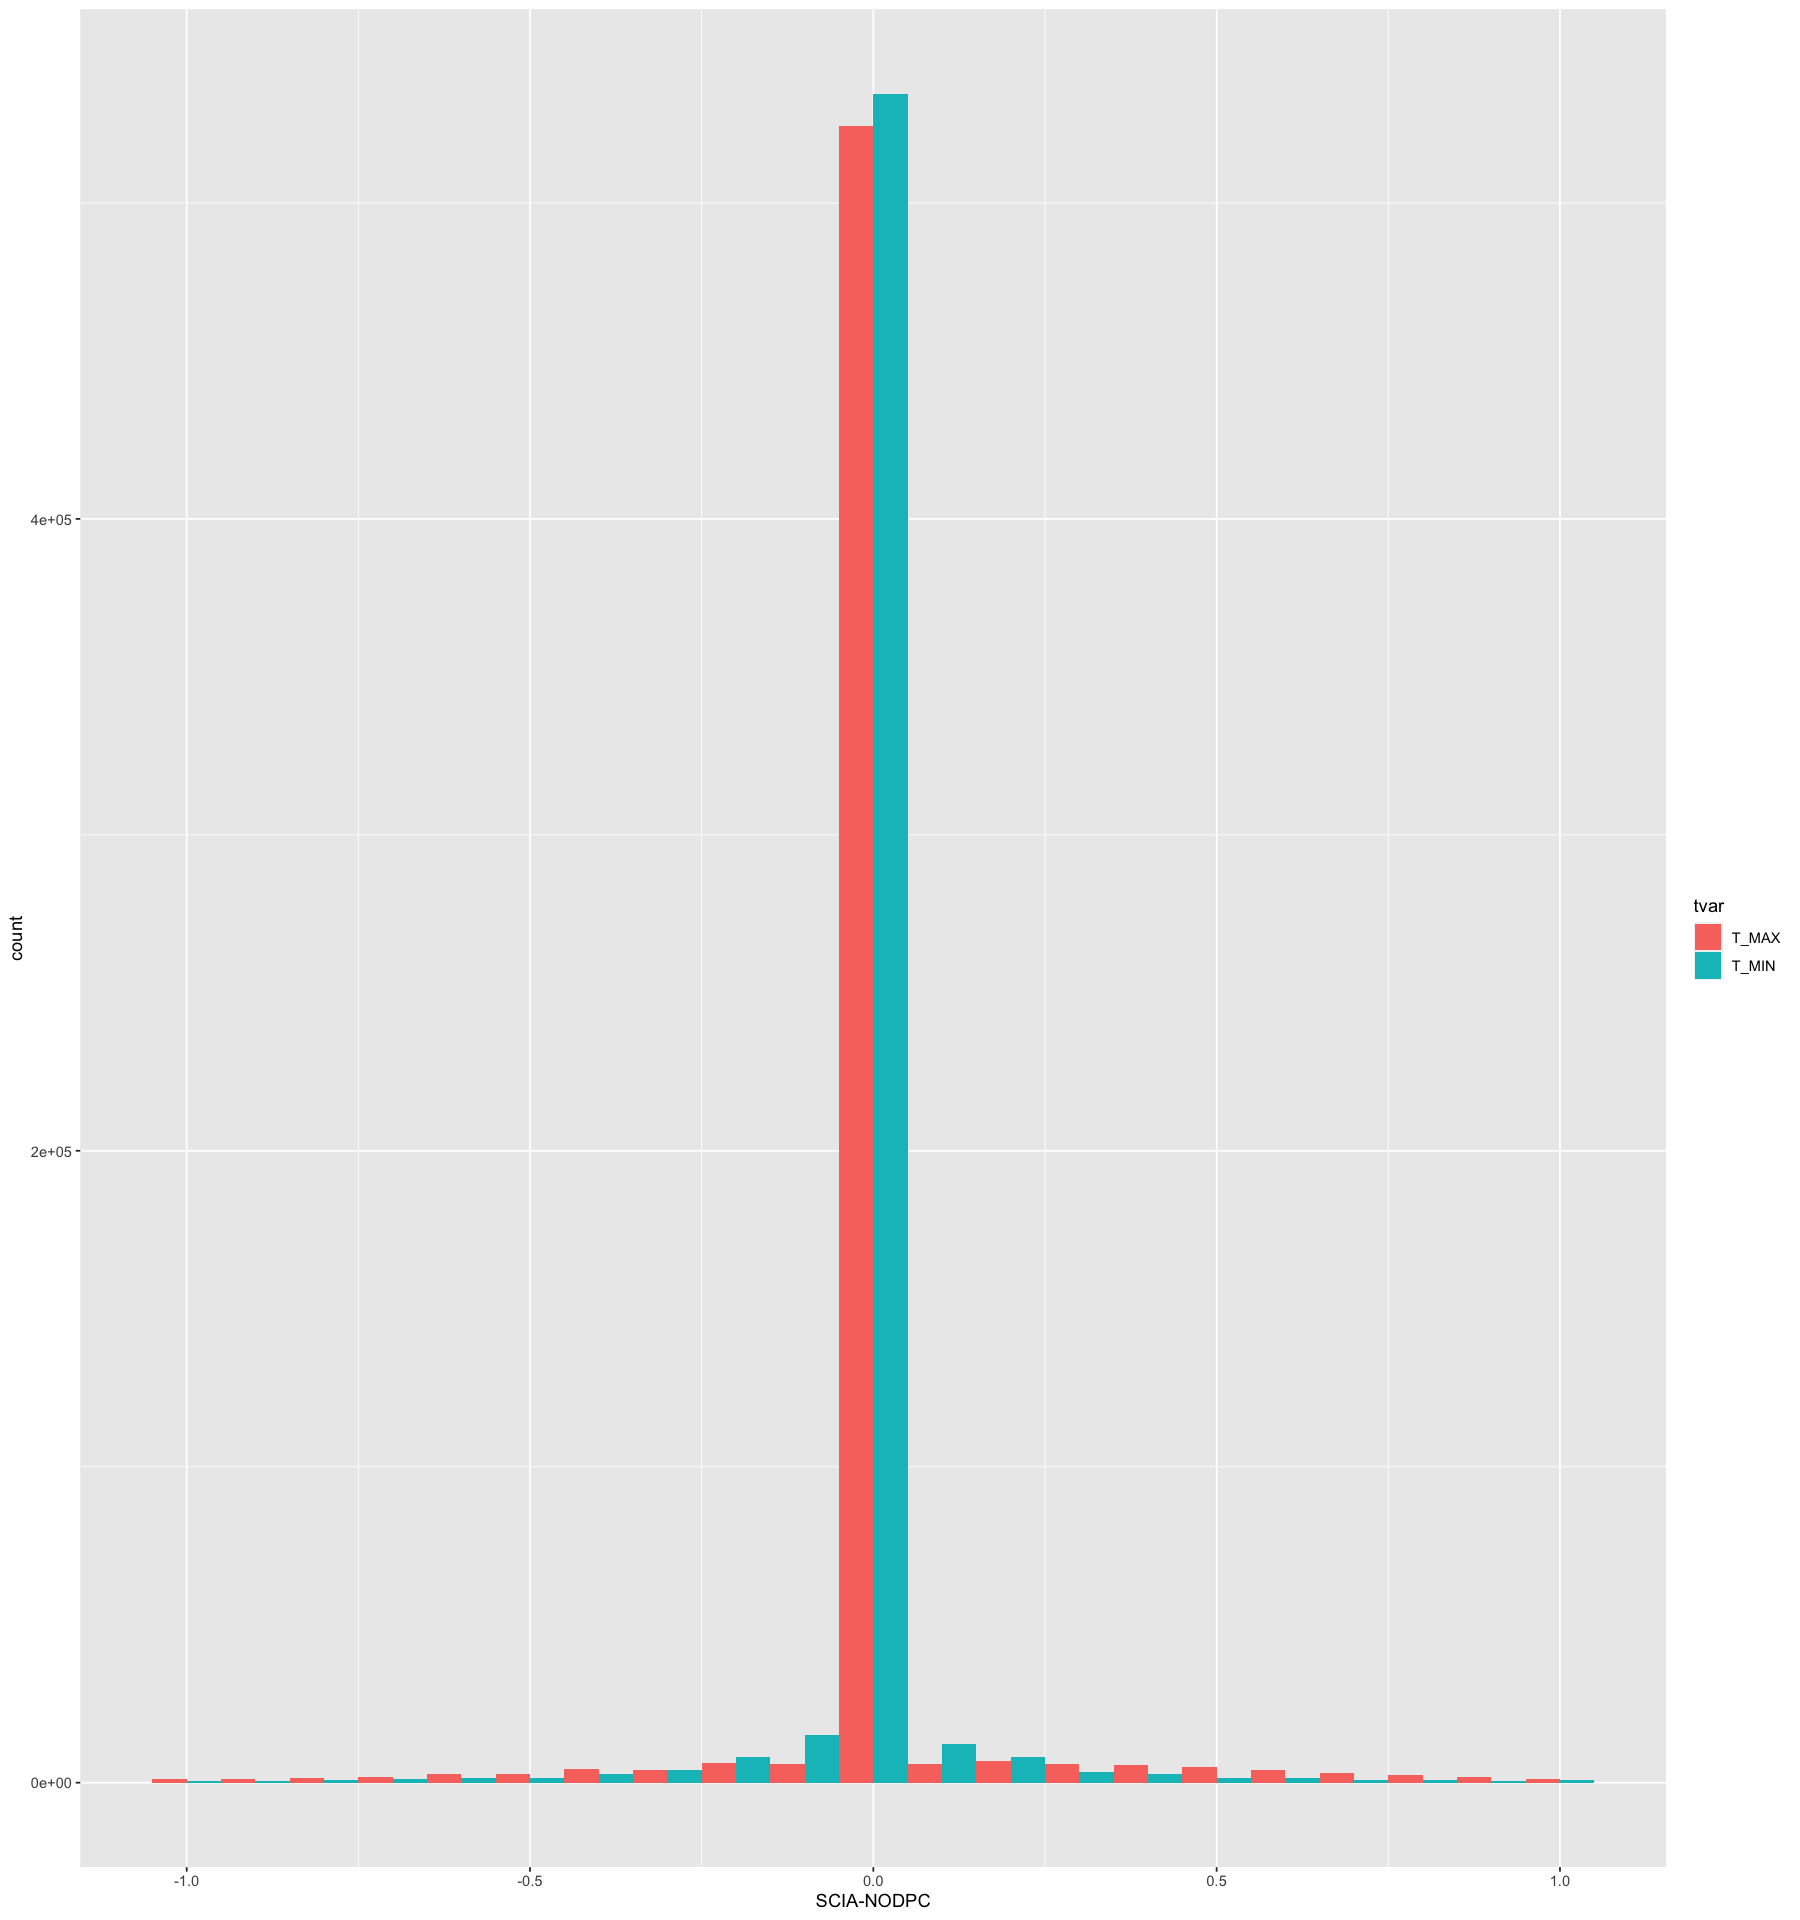

In [8]:
data <- bind_rows(
    T_MAX = d.tmax |> select(diff, elevation.x),
    T_MIN = d.tmin |> select(diff, elevation.x),
    .id = "tvar"
)
ggplot(data = data |> filter(abs(diff) <= 1.05)) +
    geom_histogram(
        aes(diff, fill = tvar),
        bins = 21,
        binwidth = 0.1,
        center = 0,
        position = "dodge",
    ) +
    labs(x = "SCIA-NODPC")
ggsave(str_glue("plots/hist_net_NODPC_both.pdf"), width = 12, height = 12)

Qualche osservazione:
- non esistono match per alcune reti, in dipendenza dall'archivio:
    - in DPC non ci sono le sinottiche;
- so che le sinottiche registrano i dati con cadenza oraria: le differenze difatti sono minime;